In [ ]:
import importlib
import itertools
import random

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import xgboost as xgb
import shap

from src import load_data, maps, embeddings

def run_spearman(df: pd.DataFrame, x: str, y: str) -> None:
    df = df[[x, y]].dropna()
    if df.empty:
        print(f"No data available for {x} and {y}.")
        return
    corr, p_value = stats.spearmanr(df[x], df[y])
    print(f"Testing correlation between {x} and {y}.")
    print(f"Spearman Correlation: {corr:.4f}")
    print(f"P-value: {p_value:.4f}\n")
    if p_value < 0.05:
        print(f"Significant correlation between {x} and {y} (p < 0.05).")

In [3]:
df_b, df_r = load_data.load_yelp_data()
df_c = load_data.load_crime_data()
df_g = maps.map_bc(df_b, df_r, df_c, grid_size = 5.0)

emb_r = np.lib.format.open_memmap("data/r_emb_large.npy")

In [4]:
df_r["month"] = df_r["date"].dt.to_period("M")
df_c["month"] = df_c["dispatch_date_time"].dt.to_period("M")

df_g_by_id = df_g.set_index("grid_id")

all_grids = df_g["grid_id"].unique()
start_month = min(df_r["date"].dt.to_period("M").min(), df_c["dispatch_date_time"].dt.to_period("M").min())
end_month = max(df_r["date"].dt.to_period("M").max(), df_c["dispatch_date_time"].dt.to_period("M").max())
all_months = pd.period_range(start=start_month, end=end_month, freq="M")

mgs = list(itertools.product(all_months, all_grids))
mgs_inv = {(m, g): i for i, (m, g) in enumerate(mgs)}

ms, gs = zip(*mgs)

df_mg_data = {
    "month": ms, 
    "grid_id": gs, 
    "population": [df_g_by_id.loc[g, "population"] for g in gs],
    "business_ids": [df_g_by_id.loc[g, "business_ids"] for g in gs],
    "review_ids": [[] for _ in mgs],
    "crime_ids": [[] for _ in mgs],
}
for key, group in df_r.sort_values(["month", "grid_id"]).groupby(["month", "grid_id"]):
    df_mg_data["review_ids"][mgs_inv[key]] = list(group["review_id"])

for key, group in df_c.sort_values(["month", "grid_id"]).groupby(["month", "grid_id"]):
    df_mg_data["crime_ids"][mgs_inv[key]] = list(group["objectid"])

df_mg = pd.DataFrame(df_mg_data)

df_mg["crime_rate"] = df_mg["crime_ids"].apply(len) / df_mg["population"]


In [ ]:
df_mg["next_month_crime_rate"] = df_mg.groupby("grid_id")["crime_rate"].shift(-1)

sum_vectors = np.zeros((len(df_mg), 3072), dtype=np.float32)
counts = np.zeros(len(df_mg), dtype=np.int32)
target_indices = pd.Series(zip(df_r["month"], df_r["grid_id"])).map(mgs_inv).values.astype(int)

np.add.at(sum_vectors, target_indices, emb_r)
np.add.at(counts, target_indices, 1)

mean_embeddings = np.full_like(sum_vectors, np.nan) # Initialize with NaN
non_zero_mask = counts > 0
mean_embeddings[non_zero_mask] = sum_vectors[non_zero_mask] / counts[non_zero_mask][:, np.newaxis]

df_mg["full_emb_score"] = list(mean_embeddings)

df_mg["d_full_emb_score"] = df_mg.groupby("grid_id")["full_emb_score"].diff()
df_mg["d_crime_rate"] = df_mg.groupby("grid_id")["crime_rate"].diff()
df_mg["d_next_month_crime_rate"] = df_mg.groupby("grid_id")["next_month_crime_rate"].diff()

In [9]:
df_ax_data = {
    "axis_name": [
        "Safety",
        "Cleanliness",
        "Wealth",
        "Orderliness",
        "Vibe",
        "Community",
        "Crowdedness",
        "Accessibility",
        "Family_Friendliness",
        "Business_Health"
    ],
    "positive_term": [
        ["safe", "secure", "safe and secure", "safe neighborhood"],
        ["clean", "well-maintained", "spotless", "well-kept"],
        ["upscale", "wealthy", "luxurious", "expensive"],
        ["quiet", "peaceful", "calm", "serene"],
        ["trendy", "modern", "hip", "new and popular"],
        ["community", "friendly", "welcoming", "strong sense of community"],
        ["bustling", "vibrant", "lively", "crowded"],
        ["easy parking", "convenient", "accessible", "easy to get to"],
        ["family friendly", "good for kids", "children playing"],
        ["thriving", "popular", "busy", "thriving local businesses"]
    ],
    "negative_term": [
        ["dangerous", "sketchy", "unsafe", "crime-ridden"],
        ["dirty", "littered", "filthy", "rundown"],
        ["cheap", "divey", "affordable", "run down"],
        ["rowdy", "chaotic", "loud", "noisy"],
        ["local spot", "hole in the wall", "neighborhood gem", "unpretentious"],
        ["isolated", "anonymous", "impersonal", "unfriendly"],
        ["empty", "deserted", "quiet", "ghost town"],
        ["difficult to find parking", "hard to get to", "inconvenient"],
        ["not for kids", "adults only", "not family friendly"],
        ["abandoned buildings", "empty storefronts", "out of business"]
    ]
}


# Create the DataFrame
df_ax = pd.DataFrame(df_ax_data)
df_ax["emb"] = [
    embeddings.normalize(np.mean(embeddings.embedding(pos), axis=0) - np.mean(embeddings.embedding(neg), axis=0))
    for _, pos, neg in df_ax.itertuples(index=False)
]

In [10]:
for name, emb in df_ax[["axis_name", "emb"]].itertuples(index=False):
    df_mg[f"d_emb_score_{name}"] = df_mg["d_full_emb_score"].apply(lambda a: a @ emb)

In [77]:
cols = [f"d_emb_score_{name}" for name in df_ax["axis_name"]] + ["population"]
df_mg_cut = df_mg.dropna(subset=["d_next_month_crime_rate", cols[0]])

df_mg_train = df_mg_cut[(df_mg_cut["month"] >= pd.Period("2005-01")) & (df_mg_cut["month"] < pd.Period("2013-01"))].copy()
df_mg_test = df_mg_cut[(df_mg_cut["month"] >= pd.Period("2013-01")) & (df_mg_cut["month"] < pd.Period("2016-01"))].copy()

# df_mg_train = df_mg_cut[(df_mg_cut["month"] >= pd.Period("2021-01")) & (df_mg_cut["month"] < pd.Period("2022-01"))].copy()
# df_mg_test = df_mg_cut[(df_mg_cut["month"] >= pd.Period("2022-01")) & (df_mg_cut["month"] < pd.Period("2023-01"))].copy()

print(f"{len(df_mg_train)} training examples, {len(df_mg_test)} testing examples")

806 training examples, 500 testing examples


In [78]:
X_train = df_mg_train[cols]
y_train = df_mg_train["d_next_month_crime_rate"]
X_test = df_mg_test[cols]
y_test = df_mg_test["d_next_month_crime_rate"]

# --- 1. Fit the XGBoost Model ---
print("\nStep 1: Fitting an XGBoost model on the semantic features...")

# Initialize the XGBoost Regressor with more restrictive parameters to reduce complexity
model = xgb.XGBRegressor(
    n_estimators=10,      # Reduced from 100
    max_depth=2,          # Reduced from 3
    learning_rate=0.1,
    subsample=0.7,
    colsample_bytree=0.7,
    # reg_alpha=1,          # Added L1 regularization
    reg_lambda=1,         # Added L2 regularization
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)


# --- 2. Print Feature Importances ---
print("\nStep 2: Displaying the model's feature importances...")
# This shows which semantic axes the model found most useful for making predictions.
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
print("Learned feature importances for each feature:")
print(feature_importances.sort_values(ascending=False))


# --- 3. Evaluate the Model ---
print("\nStep 3: Evaluating the model's performance...")

# Use the fitted model to make predictions on the train data
y_pred_train = model.predict(X_train)

# Calculate the correlation between the model's predictions and the actual outcomes
train_corr, train_p_value = stats.spearmanr(y_pred_train, y_train)

print("\n--- Performance on Train Set ---")
print(f"Spearman Correlation between predictions and actuals: {train_corr:.4f}")
print(f"P-value: {train_p_value:.4g}")

# Use the fitted model to make predictions on the test data
y_pred_test = model.predict(X_test)

# Calculate the correlation between the model's predictions and the actual outcomes
test_corr, test_p_value = stats.spearmanr(y_pred_test, y_test)

print("\n--- Performance on Test Set ---")
print(f"Spearman Correlation between predictions and actuals: {test_corr:.4f}")
print(f"P-value: {test_p_value:.4g}")

if test_p_value < 0.05:
    print("\nConclusion: The model's predictions are significantly correlated with the actual outcomes.")
    print("This suggests the model has learned a generalizable relationship.")
else:
    print("\nConclusion: The model's predictions are not significantly correlated with the actual outcomes.")
    print("This suggests the model failed to generalize to the test set.")




Step 1: Fitting an XGBoost model on the semantic features...

Step 2: Displaying the model's feature importances...
Learned feature importances for each feature:
population                         0.253633
d_emb_score_Safety                 0.238740
d_emb_score_Community              0.160063
d_emb_score_Business_Health        0.122930
d_emb_score_Vibe                   0.059750
d_emb_score_Wealth                 0.054560
d_emb_score_Cleanliness            0.039400
d_emb_score_Orderliness            0.035464
d_emb_score_Accessibility          0.021006
d_emb_score_Family_Friendliness    0.014454
d_emb_score_Crowdedness            0.000000
dtype: float32

Step 3: Evaluating the model's performance...

--- Performance on Train Set ---
Spearman Correlation between predictions and actuals: 0.1862
P-value: 1.006e-07

--- Performance on Test Set ---
Spearman Correlation between predictions and actuals: 0.1331
P-value: 0.002853

Conclusion: The model's predictions are significantly correlated

925 examples in Pre-2016 era.
1072 examples in Post-2016 era.

Training model on Pre-2016 data...
Training model on Post-2016 data...

Calculating SHAP values for: Pre-2016 Era
Generating custom SHAP summary plot for: Pre-2016 Era


/var/folders/pq/y162g_l15b7bl90j125msctm0000gq/T/ipykernel_47060/3223071071.py:85: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_yticklabels(new_yticklabels)


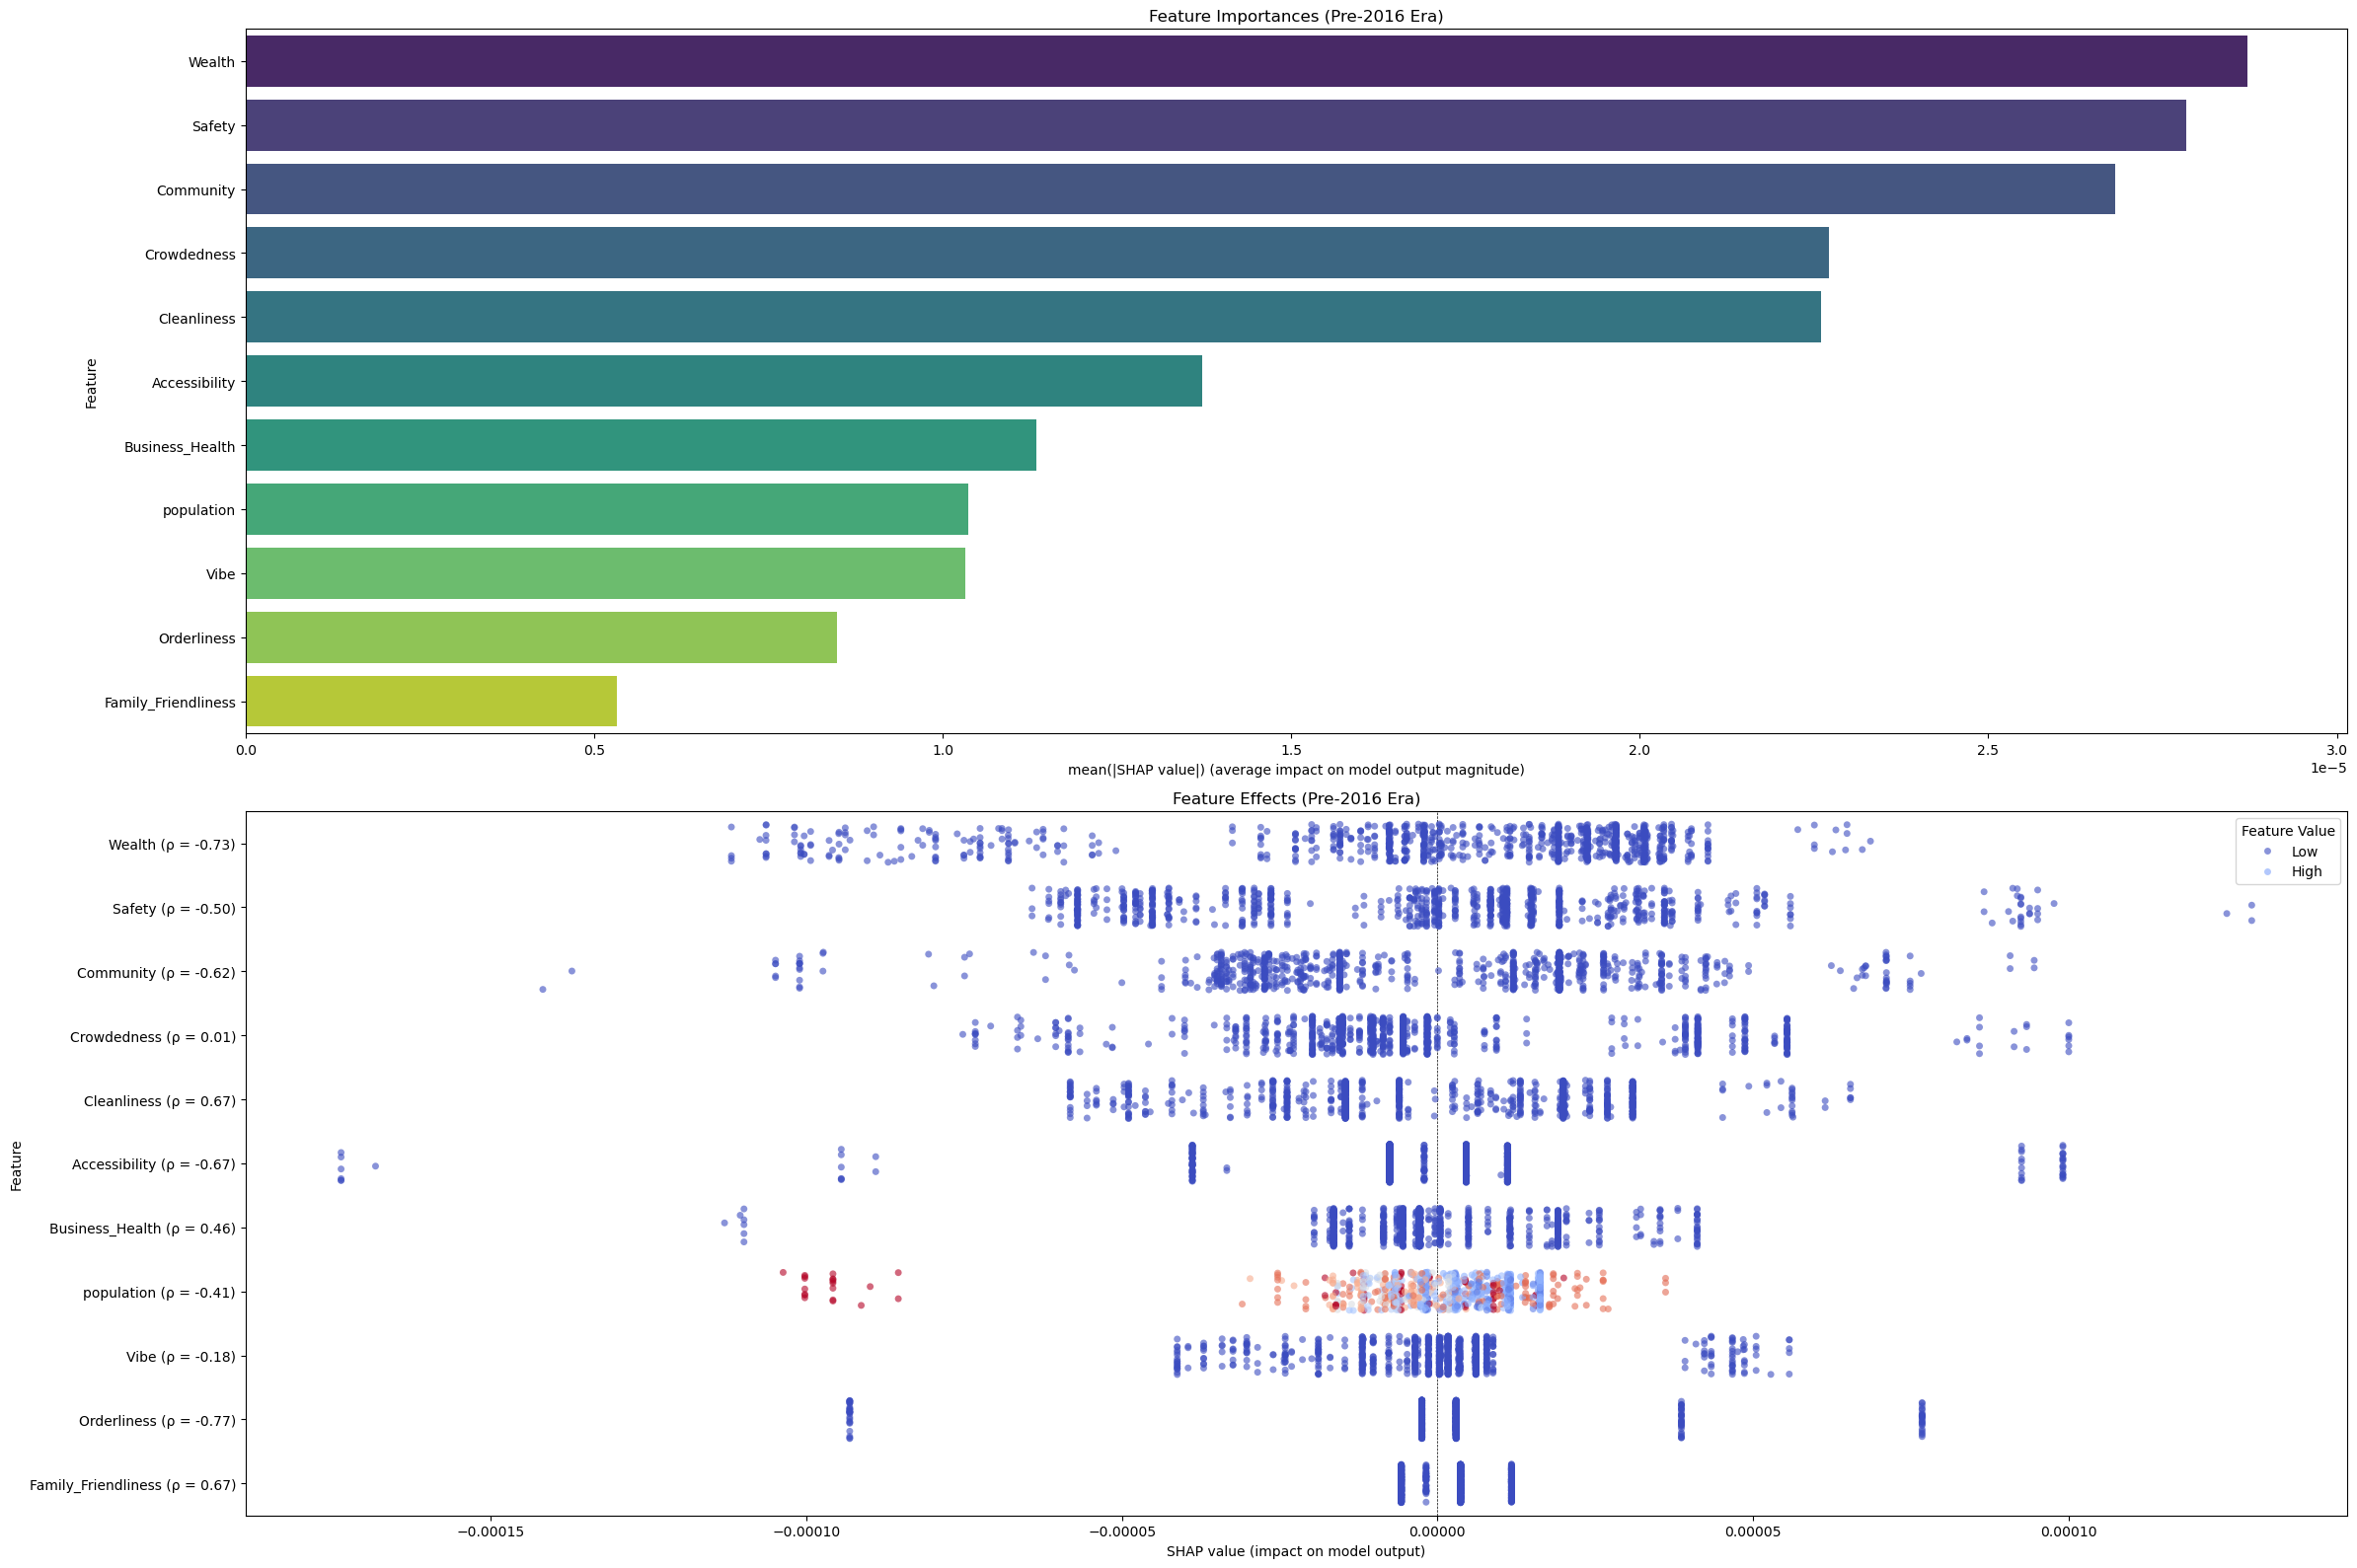


Calculating SHAP values for: Post-2016 Era
Generating custom SHAP summary plot for: Post-2016 Era


/var/folders/pq/y162g_l15b7bl90j125msctm0000gq/T/ipykernel_47060/3223071071.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = stats.spearmanr(feature_df["Feature Value"], feature_df["SHAP Value"])
/var/folders/pq/y162g_l15b7bl90j125msctm0000gq/T/ipykernel_47060/3223071071.py:85: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_yticklabels(new_yticklabels)


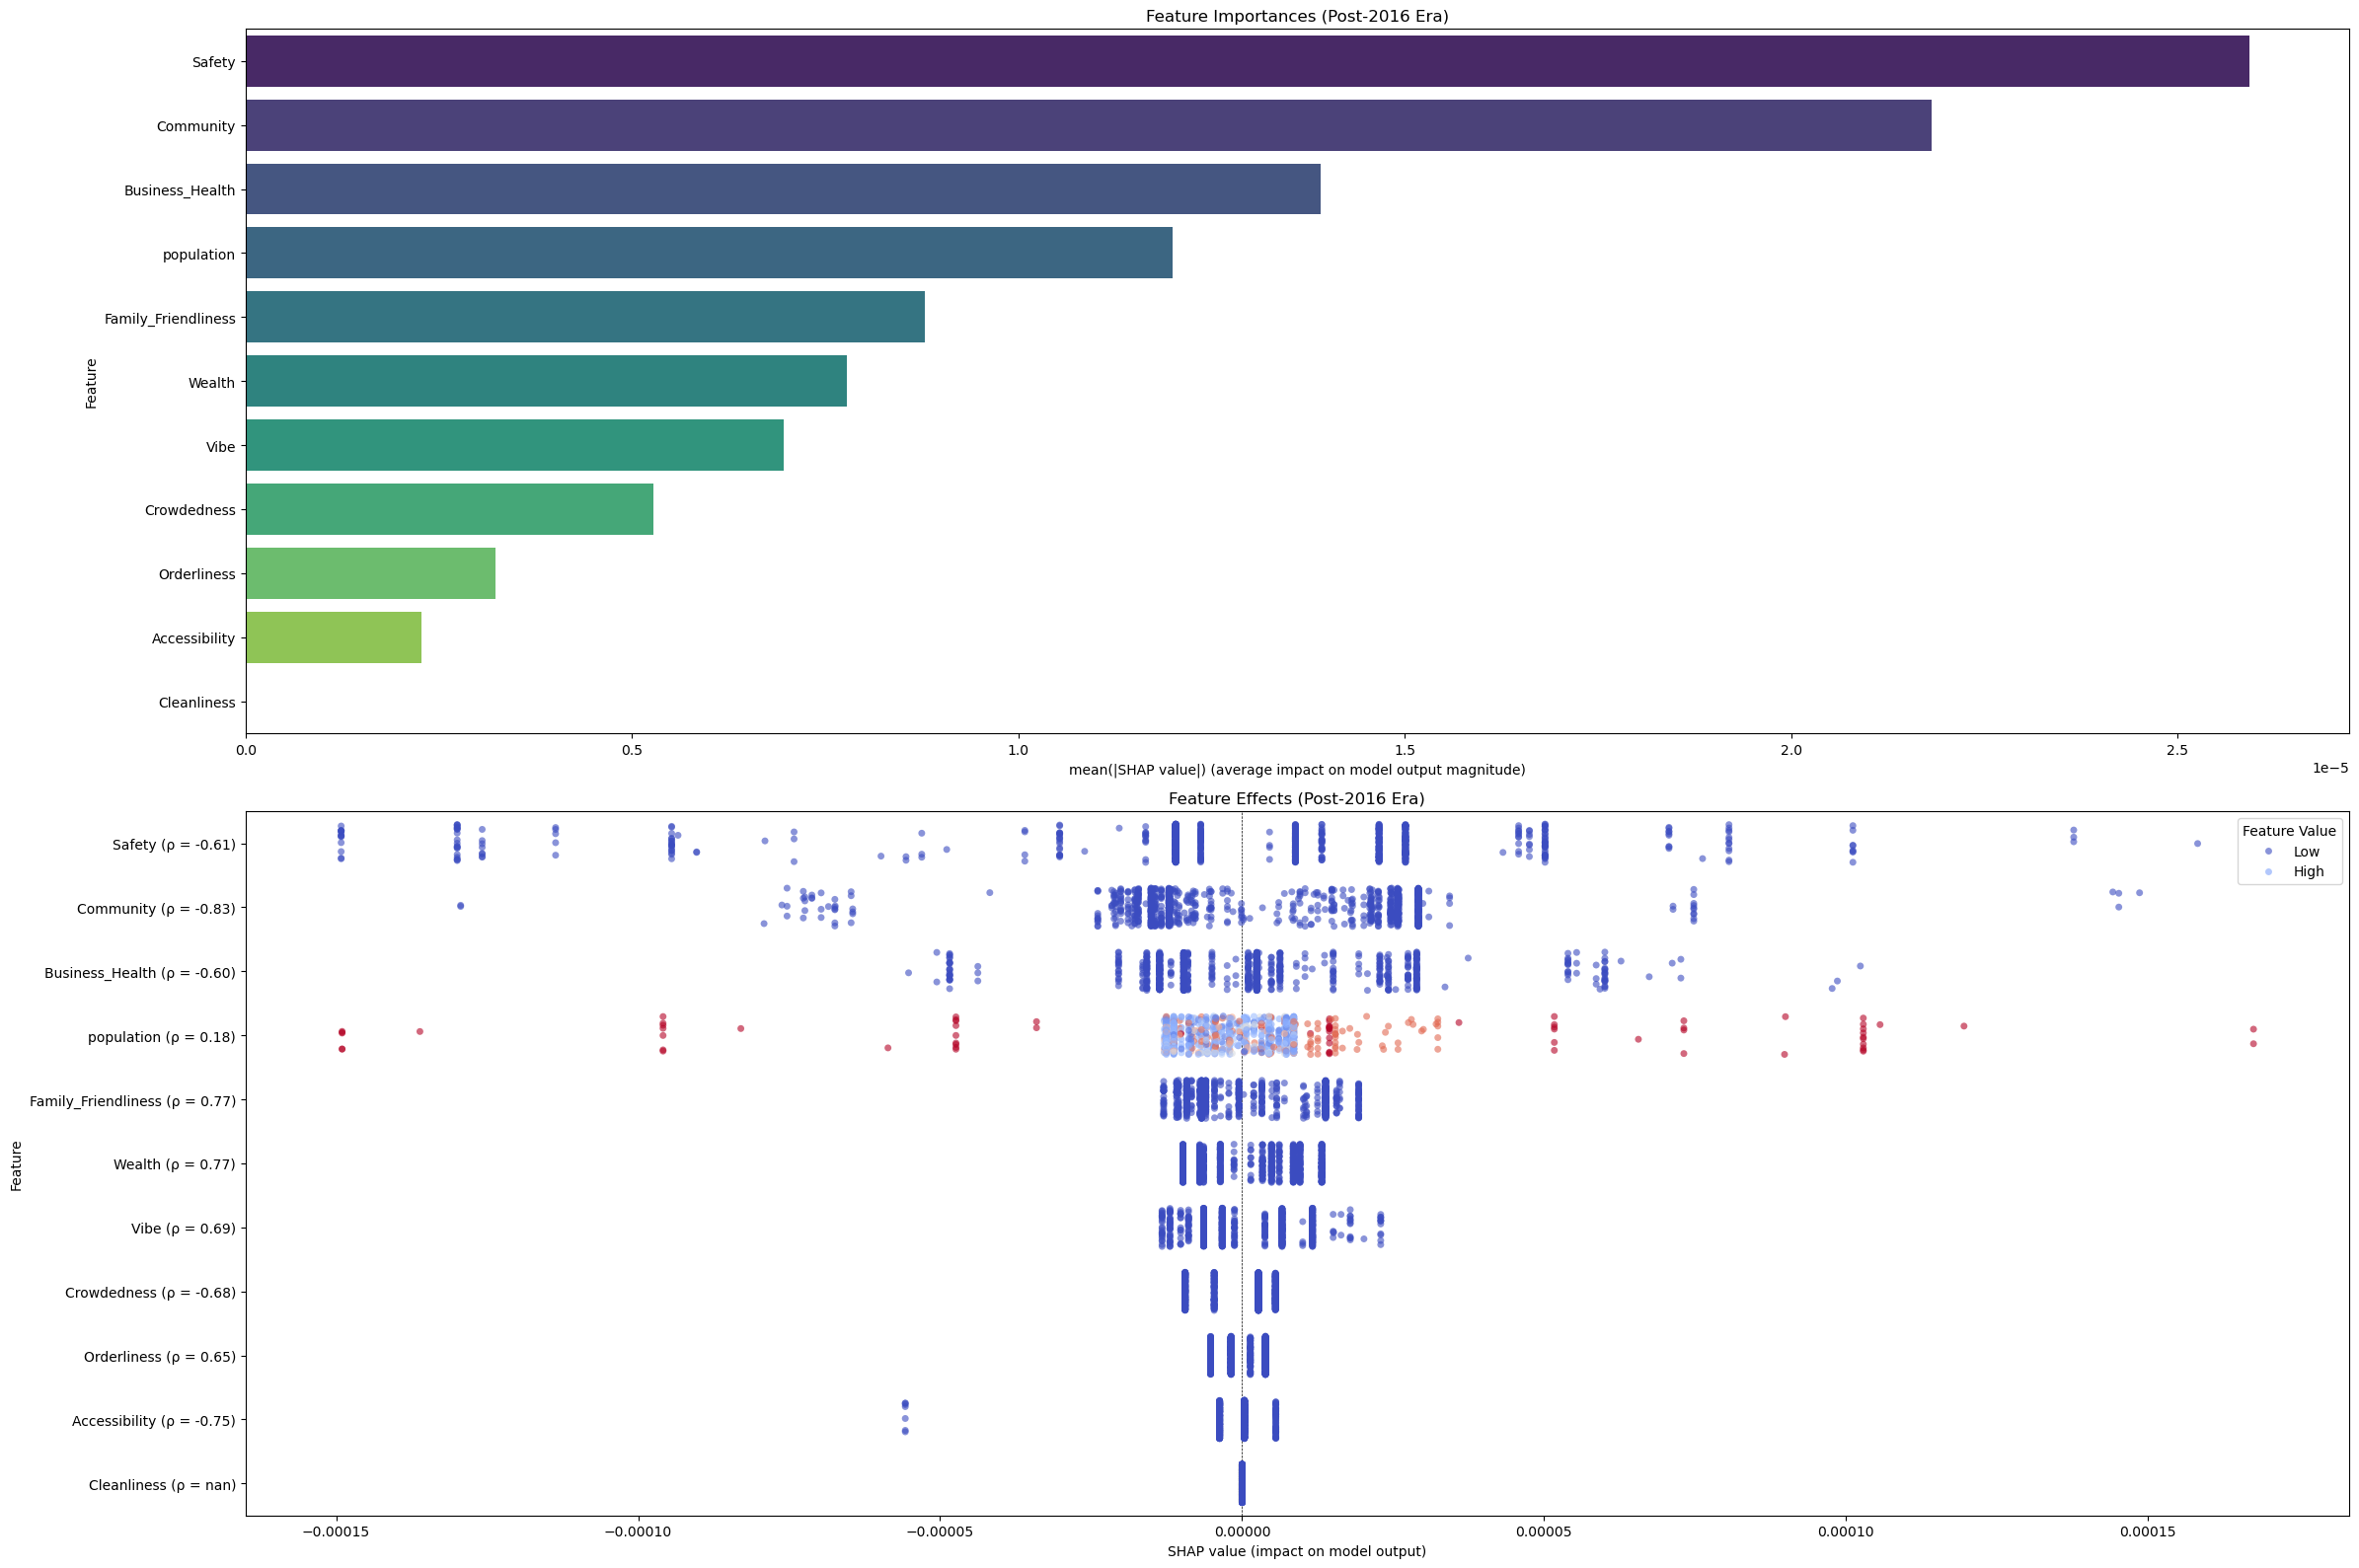

In [68]:

# Define the two time periods for comparison with the new 2016 border
df_pre = df_mg_cut[(df_mg_cut["month"] >= pd.Period("2010-01")) & (df_mg_cut["month"] < pd.Period("2016-01"))].copy()
df_post = df_mg_cut[(df_mg_cut["month"] >= pd.Period("2016-01")) & (df_mg_cut["month"] < pd.Period("2022-01"))].copy()

print(f"{len(df_pre)} examples in Pre-2016 era.")
print(f"{len(df_post)} examples in Post-2016 era.")

X_pre = df_pre[cols]
y_pre = df_pre["d_next_month_crime_rate"]
X_post = df_post[cols]
y_post = df_post["d_next_month_crime_rate"]

# --- 2. Train a Model for Each Era ---
model_params = {
    "n_estimators": 50, "max_depth": 2, "learning_rate": 0.1,
    "subsample": 0.7, "colsample_bytree": 0.7, "reg_lambda": 1,
    "random_state": 42, "n_jobs": -1
}

print("\nTraining model on Pre-2016 data...")
model_pre = xgb.XGBRegressor(**model_params)
model_pre.fit(X_pre, y_pre)

print("Training model on Post-2016 data...")
model_post = xgb.XGBRegressor(**model_params)
model_post.fit(X_post, y_post)

# --- 3. Create a Custom SHAP Plotting Function using Seaborn ---
def plot_custom_shap_summary(model, X_data, title):
    """
    Calculates SHAP values and creates custom summary plots using Seaborn.
    """
    print(f"\nCalculating SHAP values for: {title}")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_data)
    
    # Create a copy of the data for display and clean column names
    X_display = X_data.copy()
    X_display.columns = X_display.columns.str.replace("d_emb_score_", "")
    
    print(f"Generating custom SHAP summary plot for: {title}")
    
    # Create one figure with two subplots, one above the other
    fig, axes = plt.subplots(2, 1, figsize=(24, 16))
    
    # --- Plot 1: Feature Importances (Bar Plot) ---
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    importance_df = pd.DataFrame({
        "Feature": X_display.columns,
        "Importance": mean_abs_shap
    }).sort_values(by="Importance", ascending=False)
    
    sns.barplot(x="Importance", y="Feature", data=importance_df, ax=axes[0], palette="viridis", hue="Feature", legend=False)
    axes[0].set_title(f"Feature Importances ({title})")
    axes[0].set_xlabel("mean(|SHAP value|) (average impact on model output magnitude)")
    
    # --- Plot 2: Feature Effects (Beeswarm-like Plot) ---
    shap_long_df = pd.DataFrame(shap_values, columns=X_display.columns).melt(
        var_name="Feature", value_name="SHAP Value"
    )
    feature_long_df = X_display.melt(var_name="Feature", value_name="Feature Value")
    plot_df = pd.concat([shap_long_df, feature_long_df["Feature Value"]], axis=1)

    order = importance_df["Feature"].tolist()
    
    # --- NEW: Calculate correlations for plot labels ---
    corr_map = {}
    for feature in order:
        feature_df = plot_df[plot_df["Feature"] == feature]
        corr, _ = stats.spearmanr(feature_df["Feature Value"], feature_df["SHAP Value"])
        corr_map[feature] = corr
        
    # Create new labels with the correlation coefficient
    new_yticklabels = [f"{feature} (ρ = {corr_map.get(feature, 0):.2f})" for feature in order]
    
    sns.stripplot(
        x="SHAP Value", y="Feature", data=plot_df, order=order,
        hue="Feature Value", palette="coolwarm", jitter=0.3, alpha=0.6,
        ax=axes[1]
    )
    axes[1].axvline(0, color="k", linestyle="--", linewidth=0.5)
    axes[1].set_title(f"Feature Effects ({title})")
    axes[1].set_xlabel("SHAP value (impact on model output)")
    # Apply the new, more informative labels
    axes[1].set_yticklabels(new_yticklabels)
    
    handles, labels = axes[1].get_legend_handles_labels()
    if handles:
        axes[1].legend(handles[:2], ["Low", "High"], title="Feature Value", loc="best")

    plt.tight_layout()
    plt.show()

# --- 4. Generate and Compare SHAP Plots ---
plot_custom_shap_summary(model_pre, X_pre, "Pre-2016 Era")
plot_custom_shap_summary(model_post, X_post, "Post-2016 Era")

In [62]:

# --- NEW SECTION: K-S Test for Structural Break using XGBoost Errors ---
print("\n--- K-S Test for Structural Break at 2016 (using XGBoost model errors) ---")

# 1. Get the baseline error distribution from the pre-2016 model on its own data
predictions_pre = model_pre.predict(X_pre)
errors_pre = y_pre - predictions_pre

# 2. Get the test error distribution by applying the pre-2016 model to post-2016 data
predictions_post = model_pre.predict(X_post)
errors_post = y_post - predictions_post

# 3. Perform the two-sample Kolmogorov-Smirnov test
ks_statistic, p_value = stats.ks_2samp(errors_pre, errors_post)

print(f"K-S Statistic: {ks_statistic:.4f}")
print(f"P-value: {p_value:.4g}")

if p_value < 0.05:
    print("\nConclusion: The p-value is less than 0.05. We reject the null hypothesis.")
    print("This provides strong statistical evidence that the model's error distribution changed significantly, confirming a structural break in the non-linear relationship.")
else:
    print("\nConclusion: The p-value is greater than 0.05. We fail to reject the null hypothesis.")
    print("There is not enough statistical evidence to conclude that the model's error distribution changed.")




--- K-S Test for Structural Break at 2016 (using XGBoost model errors) ---
K-S Statistic: 0.0766
P-value: 0.005478

Conclusion: The p-value is less than 0.05. We reject the null hypothesis.
This provides strong statistical evidence that the model's error distribution changed significantly, confirming a structural break in the non-linear relationship.
